# Imports and Preprocessing

In [1]:
import numpy as np
import torch
import math
import pandas as pd
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
from typing import Any
from torchmetrics.functional.classification import binary_accuracy
from torchmetrics.classification import BinaryConfusionMatrix, BinaryAccuracy

In [2]:
nltk.download('stopwords', download_dir="data")

[nltk_data] Downloading package stopwords to data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# load and split dataset
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

x_train_raw,x_test_raw,y_train_raw,y_test_raw = train_test_split(df['review'].values,df['sentiment'].values, test_size=0.25, random_state=1, shuffle=True, stratify=df['sentiment'].values)

display(df.head())
print(f'number of train samples is {x_train_raw.shape}')
print(f'number of test samples is {x_test_raw.shape}')

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


number of train samples is (37500,)
number of test samples is (12500,)


In [4]:
def prepro_string(w_str):
    w_str = re.sub(r"[^\w\s]", '', w_str)
    w_str = re.sub(r"\s+", '', w_str)
    w_str = re.sub(r"\d", '', w_str)
    return w_str

def tocken_w(x_tra_raw,y_tra_raw,x_val_raw,y_val_raw, seq_len):
    word_list = []
    stop_words = set(stopwords.words('english'))
    
    for sent in x_tra_raw:
        for w in sent.lower().split():
            w = prepro_string(w)
            if w not in stop_words and w != '':
                word_list.append(w)

    corpus_ = sorted(Counter(word_list),key=Counter(word_list).get,reverse=True)[:500]
    vocab_dict = {w:i for i,w in enumerate(corpus_)}

    l_train,l_test = [],[]
    for sent in x_train_raw:
        l_train.append([vocab_dict[prepro_string(word)] for word in sent.lower().split()
                                 if prepro_string(word) in vocab_dict.keys()])
    for sent in x_val_raw:
        l_test.append([vocab_dict[prepro_string(word)] for word in sent.lower().split()
                                if prepro_string(word) in vocab_dict.keys()])

    # padding to same length with zeros
    x_train = np.zeros((len(l_train), seq_len),dtype=int)
    for i, review in enumerate(l_train):
        if len(review) != 0:
            x_train[i, -len(review):] = np.array(review)[:seq_len]

    x_test = np.zeros((len(l_test), seq_len),dtype=int)
    for i, review in enumerate(l_test):
        if len(review) != 0:
            x_test[i, -len(review):] = np.array(review)[:seq_len]

    y_train = np.array([1 if label =='positive' else 0 for label in y_train_raw])
    y_test = np.array([1 if label =='positive' else 0 for label in y_val_raw])
    return x_train, y_train,x_test, y_test, vocab_dict


In [5]:
seq_len = 100

x_train, y_train, x_test, y_test, vocab = tocken_w(x_train_raw,y_train_raw,x_test_raw,y_test_raw, seq_len=seq_len)

# Task 1

# Define Datasets, Loaders and Model 

In [7]:
# DataLoader
batch_size = 512

ds_train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
ds_test = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))


dl_train = DataLoader(ds_train, batch_size=batch_size, drop_last=True, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, drop_last=True, shuffle=False)

In [8]:
# define the transformer encoder

class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000, batch_first=False):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.batch_first = batch_first

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        if self.batch_first:
            x = x.transpose(1, 0)
        x = x + self.pe[:x.size(0):, :]
        if self.batch_first:
            x = x.transpose(1, 0)
        return self.dropout(x)

class TransformerEncoderModule(torch.nn.Module):
    def __init__(self, d_model: int, n_head: int, num_layers: int) -> None:
        super().__init__()
        self.transformer_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True, dim_feedforward=512)
        self.transformer = torch.nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.d_model = d_model
        self.n_head = n_head
        self.num_layers = num_layers
        
    def forward(self, x):
        return self.transformer(x)

In [9]:
class EncoderWrapper(pl.LightningModule):

    def __init__(self, 
        loss: callable, 
        lr: float,
        embedding: torch.nn.Module,
        pe: torch.nn.Module,
        transformer: torch.nn.Module,
        class_head: torch.nn.Module,
    ) -> None:
        super().__init__()

        self.loss = loss
        self.lr = lr
        
        self.embedding = embedding
        self.pe = pe
        self.transformer = transformer
        self.class_head = class_head
        
        # eval stuff
        self.val_acc = BinaryAccuracy()
        self.val_conf_mat = BinaryConfusionMatrix(threshold=0.5)

        self.test_acc = BinaryAccuracy()
        self.test_conf_mat = BinaryConfusionMatrix(threshold=0.5)       

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        emb = self.embedding(x) * math.sqrt(self.transformer.d_model)
        pe_emb = self.pe(emb)
        out = self.transformer(pe_emb)
        out = self.class_head(out)
        return out.squeeze()

    def _step(self, batch) -> torch.Tensor:
        x, y = batch
        pred  = self.forward(x)
        loss = self.loss(pred, y.float())
        return pred, loss

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        pred, loss = self._step(batch)
        self.log("train/loss", loss)
        acc = binary_accuracy(pred, batch[-1])
        self.log("train/acc", acc)
        return loss
    
    def _eval_step(self, batch, conf, acc):
        pred, loss = self._step(batch)
        acc.update(pred, batch[-1])
        conf.update(pred, batch[-1])

        return loss

    def _eval_epoch_end(self, eval_type, acc, conf_mat):
        acc_val = acc.compute()
        conf_val = conf_mat.compute()
        print(f"{eval_type} Accuracy: {acc_val.data}")
        print(f"{eval_type} Conf Mat: {conf_val.data}")
        self.log(f"{eval_type}/acc", acc_val)
        self.conf_mat = conf_val.detach()
        #self.log(f"{eval_type}/conf", conf_val)

        
    def test_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        loss = self._eval_step(batch, self.test_acc, self.test_conf_mat)

    def test_epoch_end(self, outputs) -> None:
        self._eval_epoch_end("Test", self.test_acc, self.test_conf_mat)

    def validation_step(self, batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        loss = self._eval_step(batch, self.val_acc)
        self.log("test", loss)

    def validation_epoch_end(self, outputs) -> None:
        self._eval_epoch_end("Val",  self.val_acc, self.val_conf_mat)
                
    def configure_optimizers(self) -> Any:
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optim

In [10]:
torch.cuda.empty_cache()

In [11]:
log_intervall = 10
epochs = 20
lr=1e-3
criterion = torch.nn.BCELoss()

vocab_size = len(vocab)
embedding_dim = 64
num_layers = 5
n_head = 2
num_layers = 2

model_wrapper = None
arch = None
torch.cuda.empty_cache()

emb = torch.nn.Embedding(vocab_size, embedding_dim)

pos_encoding = PositionalEncoding(d_model=embedding_dim, batch_first=True)
transformer = TransformerEncoderModule(d_model=embedding_dim, n_head=n_head, num_layers=num_layers)

classification_head = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(embedding_dim * seq_len, 1),
    torch.nn.Sigmoid(),
)

arch = torch.nn.Sequential(transformer, classification_head)

model_wrapper = EncoderWrapper(
    loss=criterion, 
    lr=lr,
    embedding=emb,
    pe=pos_encoding,
    transformer=transformer,
    class_head=classification_head
)

# Display some model information

In [12]:
!pip install torchinfo

In [13]:
from torchinfo import summary
torch.cuda.empty_cache()
summary(model_wrapper, input_data=next(iter(dl_train))[0])

Layer (type:depth-idx)                             Output Shape              Param #
EncoderWrapper                                     [512]                     --
├─Embedding: 1-1                                   [512, 100, 64]            32,000
├─PositionalEncoding: 1-2                          [512, 100, 64]            --
│    └─Dropout: 2-1                                [512, 100, 64]            --
├─TransformerEncoderModule: 1-3                    [512, 100, 64]            83,008
│    └─TransformerEncoder: 2-2                     [512, 100, 64]            --
│    │    └─ModuleList: 3-1                        --                        166,016
├─Sequential: 1-4                                  [512, 1]                  --
│    └─Flatten: 2-3                                [512, 6400]               --
│    └─Linear: 2-4                                 [512, 1]                  6,401
│    └─Sigmoid: 2-5                                [512, 1]                  --
Total params: 287,4

In [14]:
# Display memory availability on the graphics card. I hat a little bit of trouble with it initaly
torch.cuda.empty_cache()

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

torch.cuda.mem_get_info()

total    : 17071734784
free     : 16298803200
used     : 772931584


(16298803200, 17071734784)

# Train and Test the model

In [15]:
trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1, log_every_n_steps=log_intervall)
trainer.fit(model_wrapper, dl_train)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:109: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

In [16]:
trainer.test(model_wrapper, dl_test)

Testing: 0it [00:00, ?it/s]

Test Accuracy: 0.8063151240348816
Test Conf Mat: tensor([[5089, 1049],
        [1331, 4819]], device='cuda:0')


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test/acc          │    0.8063151240348816     │
└───────────────────────────┴───────────────────────────┘

[{'Test/acc': 0.8063151240348816}]

In [17]:
conf_mat = model_wrapper.conf_mat.cpu().numpy()

<AxesSubplot:>

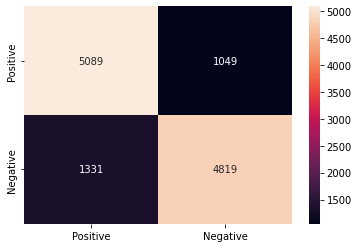

In [18]:
sns.heatmap(conf_mat,annot=True, fmt='g', xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])

# Task 2

I am not really sure what to do with this task...  
So here is a short interpretation on my part.
- First: Just Display the Positional Encoding up to our seq_len

Second, see how shifts modify the output.
- Use some sample from our dataloader and embed it with our learned embedding 
- Shift by k units
- Apply our Positional Encoding
- See what happens

- Visualize 

[Text(0.5, 1.0, 'Positional Encoding'),
 Text(114.0, 0.5, 'Sequence Dimenion'),
 Text(0.5, 114.0, 'Embedding Dimensions')]

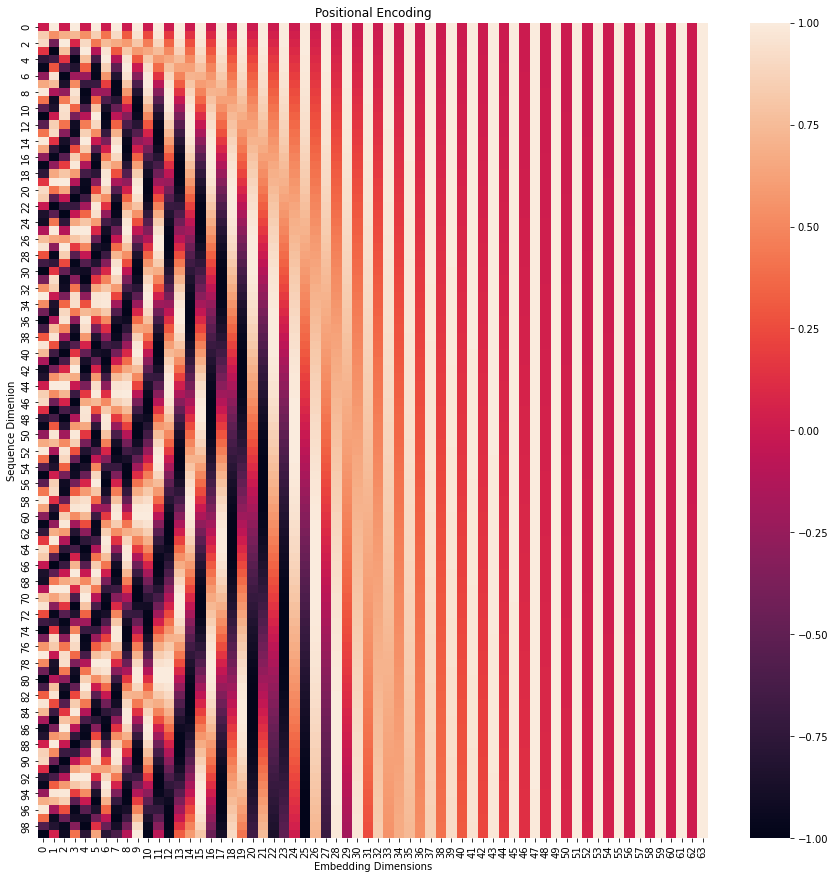

In [19]:
# Display PE only
pe = pos_encoding.pe[:seq_len, 0, ::] # this is encoded as (seq_len, batch_size, encoding_dim) 
plt.figure(figsize=(15, 15))
sns.heatmap(pe.detach().numpy()).set(title="Positional Encoding", ylabel="Sequence Dimenion", xlabel="Embedding Dimensions")

In [20]:
# get a sample batch

x0, y0 = next(iter(dl_test))
# x0 = torch.randint(0,seq_len,(batch_size, seq_len))
# we can reuse the trained layers
# embed input
embedding = emb(x0) * math.sqrt(embedding_dim)
encodings = [pos_encoding(torch.roll(embedding, i))[0, ::, ::].detach().numpy() for i in range(0, 21, 5)] 
# get one sample

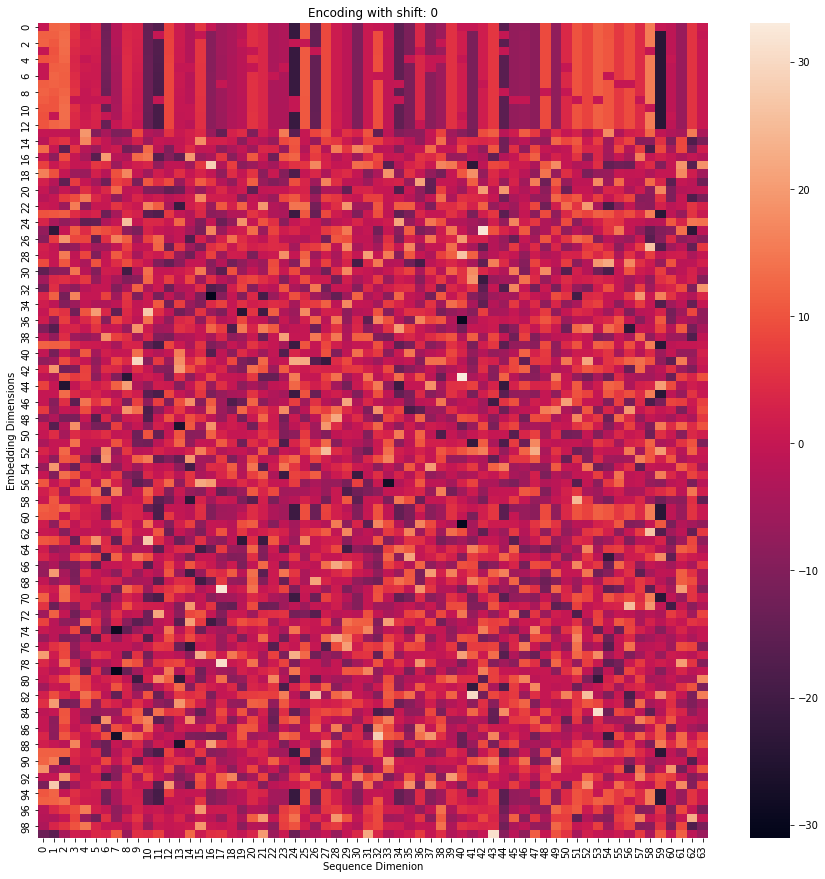

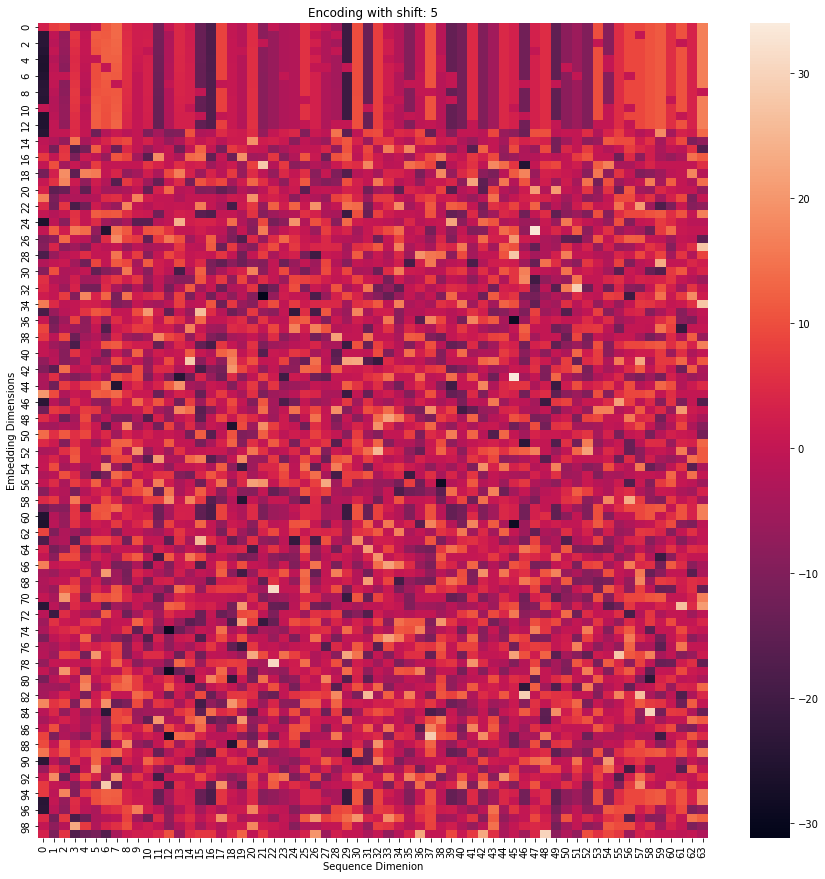

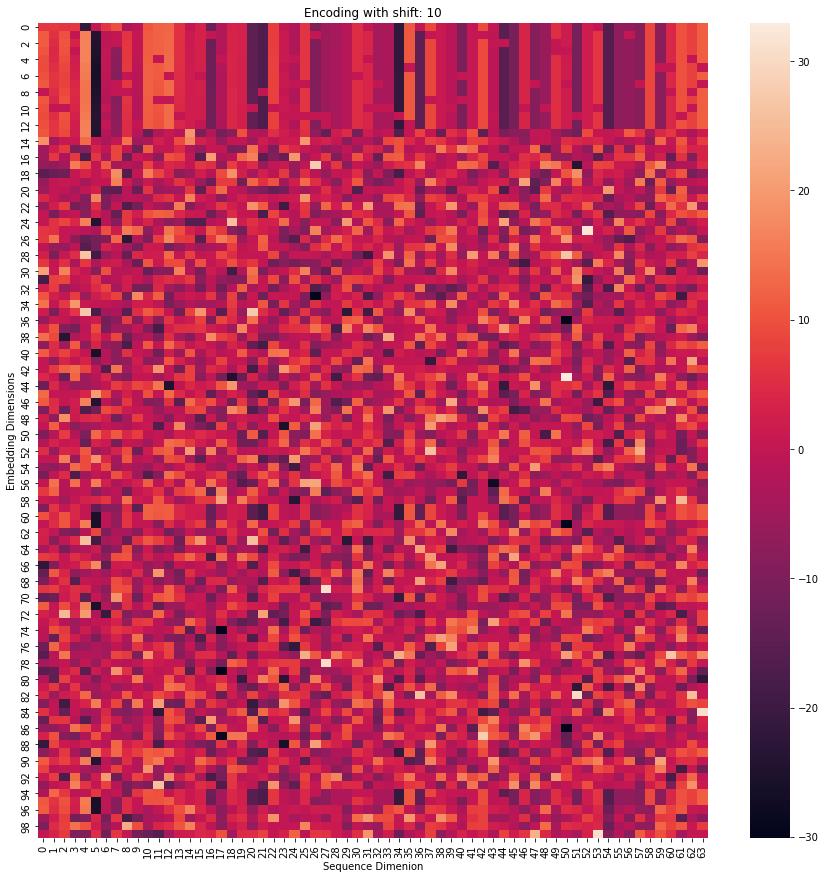

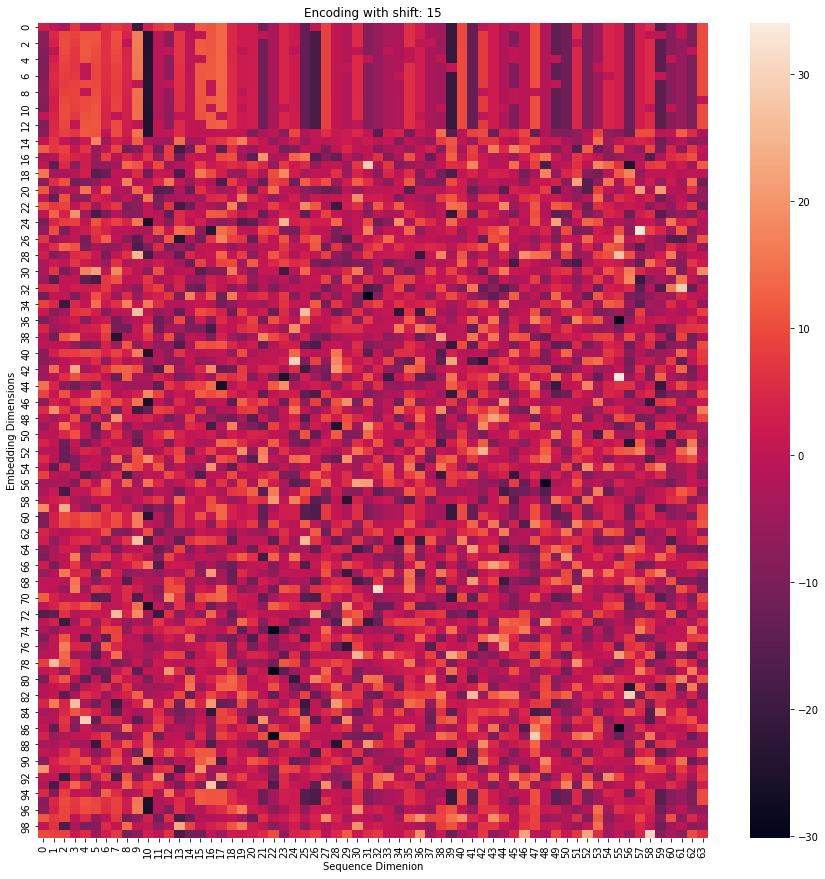

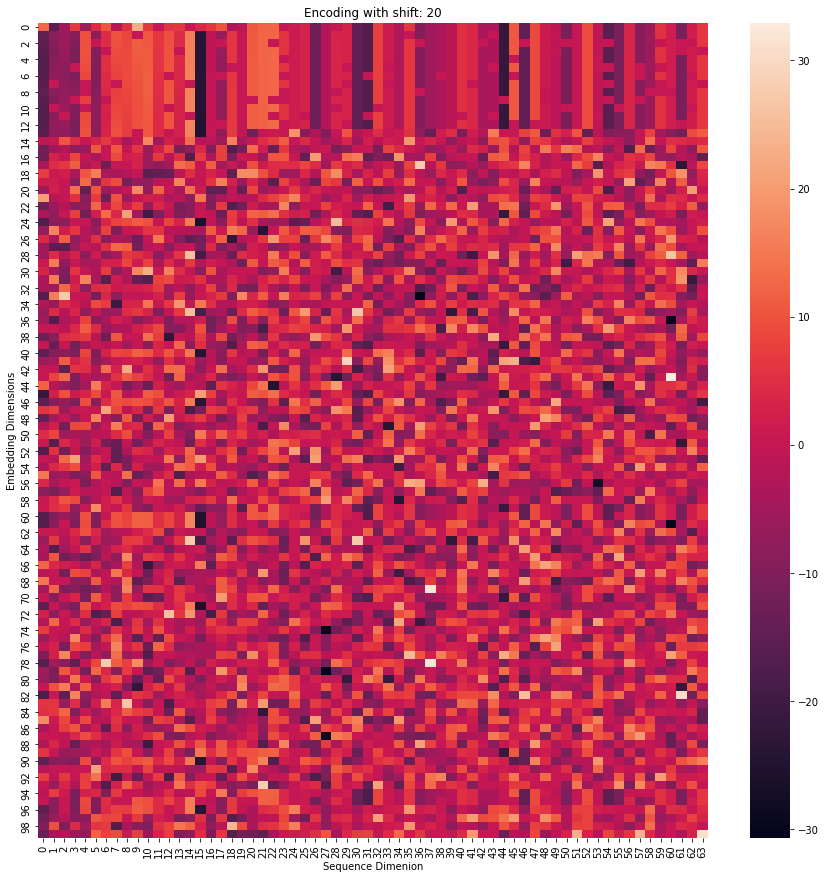

In [21]:
for i, encoding in enumerate(encodings):
    plt.figure(figsize=(15, 15))
    sns.heatmap(encoding).set(title=f"Encoding with shift: {i * 5}", xlabel="Sequence Dimenion", ylabel="Embedding Dimensions")

# Findings

- We can see, that there are around 100 - 14 encoded words in the sequence.
- We can see, shift(pe(emb(x0))) = pe(shift(emb(x0))) We can see this easier in the top part or if we focus on dark points